# Homework 2


This week's homework will be done entirely in a jupyter notebook. Please submit your homework to Canvas as a single .ipynb file. Note that this assignment should be done in pairs.

Please indicate both team members' names below.

- Partner 1 name & number of hours spent on assignment: Jordan Carlin -- 6 hours
- Partner 2 name & number of hours spent on assignment: Korin Aldam-Tajima -- 6 hours


In [1]:
%matplotlib inline

In [2]:
# here are some useful packages that you may need
import numpy as np
from scipy.signal import stft, resample_poly
from scipy.signal.windows import hann
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import IPython.display as ipd

### Problem 1: Re-implementation


#### Part a: myDFT


In the myDFT function below, you will implement the DFT. In this function, you should do the following:

- fill in the coefficients of A row by row using vectorized code. You should not have a nested for loop.
- perform a matrix multiplication to calculate the DFT. You may use [numpy.matmul](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html) or the shorthand notation `@` to do matrix multiplication.
- return the result as a 1-D numpy array

Be careful about 1-D vs 2-D numpy arrays (e.g. a length-8 vector versus a 1x8 matrix). You can remove vacuous dimensions with [numpy.squeeze](https://docs.scipy.org/doc/numpy/reference/generated/numpy.squeeze.html).


In [3]:
def myDFT(x):
    """
    Calculates the DFT of the input signal x.
    """
    N = len(x)
    A = np.zeros((N, N), dtype=np.complex128)

    ### START CODE HERE ###
    for k in range(N):
        A[k, :] = np.exp((-1j * 2 * np.pi * k * np.arange(N)) / N)

    X = x @ A
    ### END CODE HERE

    return X

Insert code below to:

- create a vector of 32 randomly generated numbers using [numpy.random.randn](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html)
- calculate the DFT using your myDFT function
- calculate the DFT using the [numpy.fft.fft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html#numpy.fft.fft) function
- verify that the outputs match using [numpy.allclose](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html)


In [4]:
### START CODE HERE ###
test_data = np.random.randn(32)

my_result = myDFT(test_data)

fft_result = np.fft.fft(test_data)

if np.allclose(my_result, fft_result):
    print("The results match.")
else:
    print("The results do not match.")

### END CODE HERE ###

The results match.


#### Part b: mySTFT


In the mySTFT function below, you will implement the STFT. In the function, you should do the following:

- fill in matrix S column by column. You may use [scipy.signal.hann](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.hann.html) for the window function, and [numpy.fft.fft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html) for the FFT.
- calculate f and t
- discard the upper half of f and S, so that only the first `N/2 + 1` frequencies are returned.


In [5]:
def mySTFT(x, fs, N, noverlap):
    """
    Calculates the STFT of an input signal.

    Arguments
    ---------
    x: the input signal
    fs: the sampling rate (Hz)
    N: the FFT size
    noverlap: the number of samples that overlap between consecutive analysis windows

    Returns
    -------
    f: an array specifying the frequencies in Hz of the STFT bins
    t: an array specifying the time offsets of the analysis windows (center of window)
    S: the STFT matrix.  Only the lower N/2 + 1 frequency bins are returned.
    """
    hop = N - noverlap
    offsets = np.arange(0, len(x) - N + 1, hop)
    S = np.zeros((N, len(offsets)), dtype=np.complex128)

    ### START CODE HERE ###
    upper_bound = N
    for i, m in enumerate(offsets):
        S[:, i] = np.fft.fft(x[m : upper_bound + m] * hann(upper_bound))

    f = np.arange(N // 2 + 1) * fs / N
    t = offsets / fs
    S = S[0 : N // 2 + 1,]

    ### END CODE HERE ###

    return f, t, S

Use your implementation to compute the STFT for a 4 second long, 8kHz audio signal containing a pure sinusoid with frequency 440 Hz. Use a window size of 512 and a hop size of 128. Verify that your `t` and `f` variables match the outputs from [scipy.signal.stft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html).


In [6]:
(fs, winsize, hop) = (8000, 512, 128)
(f, dur) = (440, 4)
a = np.cos(2 * np.pi * f / fs * np.arange(dur * fs))

### START CODE HERE ###

# My version
f1, t1, S1 = mySTFT(a, fs, winsize, winsize - hop)

# Scipy version version
f2, t2, S2 = stft(
    a, fs=fs, window=hann(winsize, sym=False), nperseg=winsize, noverlap=winsize - hop
)

# The lengths of the t arrays differ due to how the STFT is computed at the edges.
# The scipy version has extra frames at the end.
if np.allclose(t1, t2[0:247]):
    print("The `t` results match.")
else:
    print("The `t` results do not match.")

if np.allclose(f1, f2):
    print("The `f` results match.")
else:
    print("The `f` results do not match.")

### END CODE HERE ###

The `t` results match.
The `f` results match.


Due to various implementation differences, your STFT matrix may not exactly match [scipy.signal.stft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html), but the plotted images should look the same. Use the plotting code below to display the two spectrograms as images, and verify that they look the same.


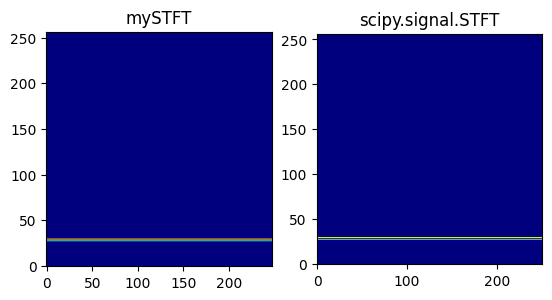

In [7]:
plt.subplot(121)
plt.imshow(np.abs(S1), origin="lower", cmap="jet")
plt.title("mySTFT")
plt.subplot(122)
plt.imshow(np.abs(S2), origin="lower", cmap="jet")
plt.title("scipy.signal.STFT")
plt.show()

### Problem 2: DFT & Sound (part 1)


In this section, you should do the following:

- Record yourself singing “ah” at four different pitches: C4, E4, G4, and C5. Hold each
  note for at least 3 seconds. You can use [Audacity](https://www.audacityteam.org/) to record on your laptop.
- Read in the audio file using [scipy.io.wavfile.read](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html) and downsample to 22050 Hz using [scipy.signal.resample_poly](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.resample_poly.html).
- Verify that you have loaded the audio correctly by embedding the audio in the notebook and listening to it. You can use [IPython.display.Audio](https://ipython.org/ipython-doc/dev/api/generated/IPython.display.html).
- Extract 4 different segments of audio corresponding to the four notes. Each segment should be exactly 3 seconds long.
- Compute the DFT for the four segments, and compare the magnitude and phase plots. Include well-designed plots that are easy to interpret (zoomed in on interesting part, axes labeled with intuitive units). What are the analog frequencies that correspond to spikes in the DFT magnitude plots? What is the relationship of the spike locations to each other? Comment on the differences and similarities between the plots.


Use as many code and Markdown cells as needed below to complete these tasks. You should define appropriate functions (e.g. for extracting segments or plotting the DFT) where appropriate, rather than copying and pasting code multiple times. Please include your explanations in Markdown cells.


In [8]:
### INSERT CODE AND MARKDOWN CELLS BELOW ###


def load_audio(filename: str, target_sample_rate: int) -> np.ndarray:
    """Load an audio file and resample it to the target_sample_rate"""
    sr_orig, x_orig = read(filename)
    return resample_poly(np.array(x_orig), target_sample_rate, sr_orig)

In [9]:
# Load and play audio
sr = 22050
x0 = load_audio("4notes-as-long-as-possible.wav", sr)
ipd.Audio(x0, rate=sr)

In [10]:
def extract_single_note(x, fs, search_start) -> tuple[np.ndarray, int]:
    """
    Extract a single 3 second note from the audio signal. Start searching from search_start.
    Looks for a signal that is at least 70% of the max amplitude. Returns the note and the index
    that the note ends at (not the end of the 3 seconds, but when the note actually ends based on amplitude).
    """
    note_length = 3 * fs
    # Find beginning of note based on when the signal is at least half the max
    threshold = 0.7 * np.max(np.abs(x))
    min_threshold = 0.000002 * np.max(np.abs(x))
    note_start = search_start
    for i, samp in enumerate(x[search_start:]):
        if np.abs(samp) >= threshold:
            note_start = i + search_start
            break

    note_end = note_start + note_length
    while note_end < len(x) and np.abs(x[note_end]) > min_threshold:
        note_end += 5

    # print(f"{note_start=}, {note_end=}")

    return (x[note_start : note_start + note_length], note_end)


def extract_notes(x, fs) -> list[np.ndarray]:
    """Extract 3-second snippets of individual notes from the audio signal x."""
    notes = []

    # Find beginning of note based on when the signal is at least half the max
    search_start = 0
    while True:
        note, note_end = extract_single_note(x, fs, search_start)
        notes.append(note)
        search_start = note_end + 1 * fs
        if search_start >= len(x):
            break

    return notes


In [11]:
# Extract notes
notes = extract_notes(x0, sr)

print(len(notes))
for note in notes:
    ipd.display(ipd.Audio(note, rate=sr))

4


In [12]:
def plot_fft(x: np.ndarray, note_fft: np.ndarray, note: str) -> None:
    """Plot the magnitude and phase of the FFT of a note."""
    plt.plot(x, np.abs(note_fft))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(f"Magnitude of FFT: {note}")
    plt.xlim(0, 2000)
    plt.locator_params(axis="x", nbins=15)
    plt.show()
    half = len(x) // 2
    plt.plot(x[:half], np.angle(note_fft[:half]))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (Radians)")
    plt.title(f"Phase of FFT: {note}")
    plt.show()

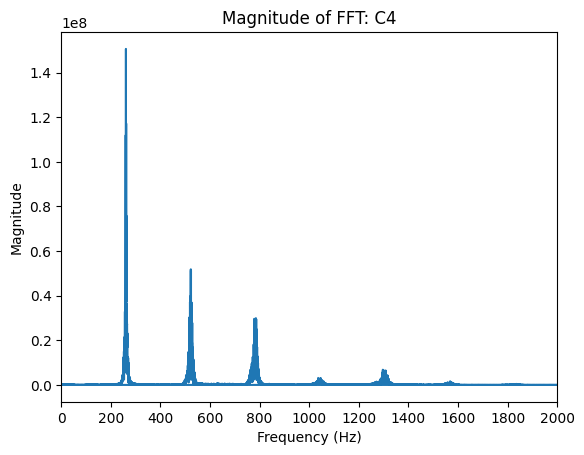

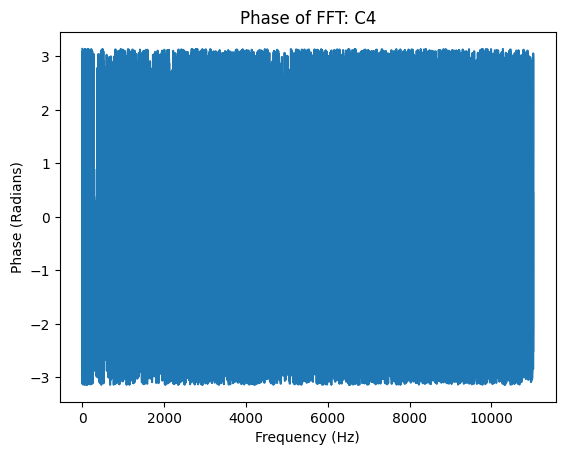

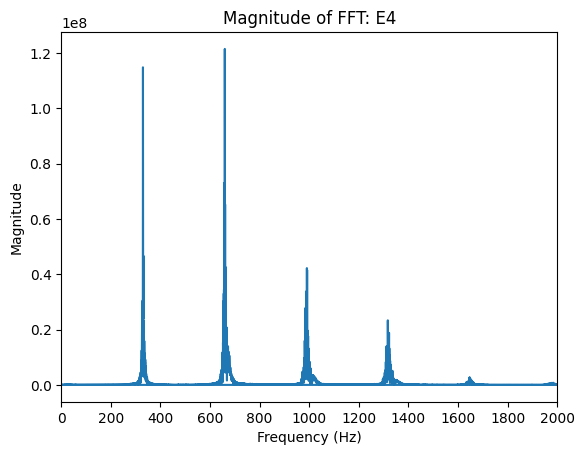

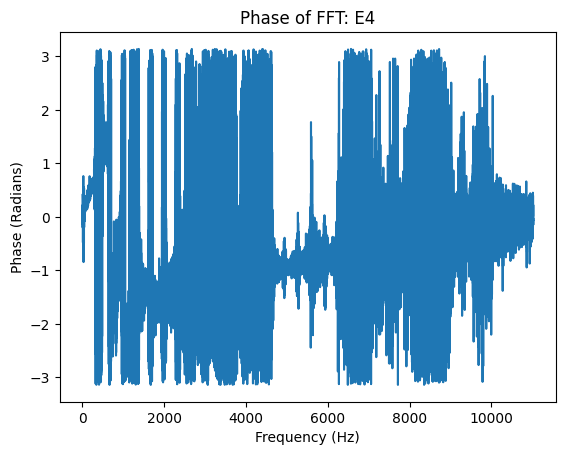

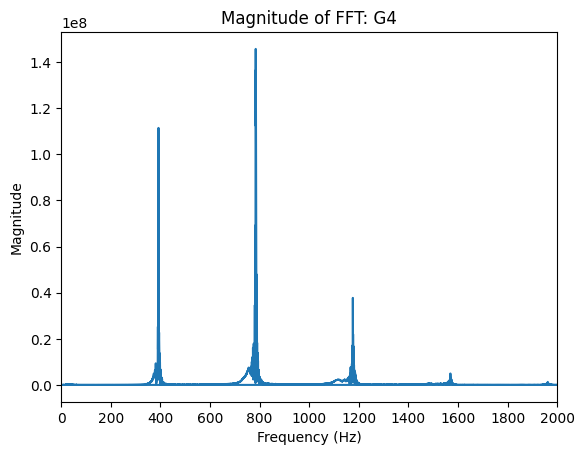

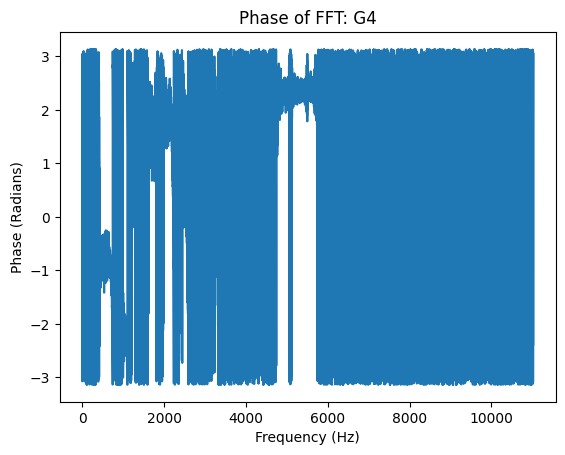

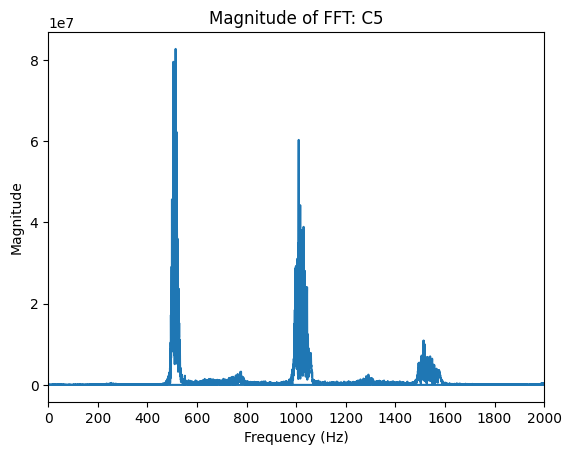

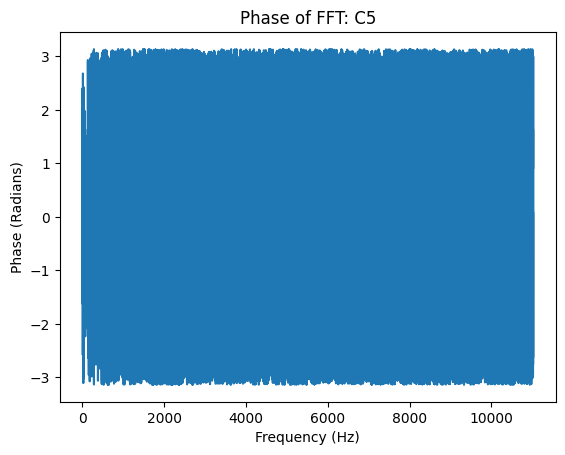

In [13]:
# Plot FFTs of extracted notes
for i, note in enumerate(notes):
    note_fft = np.fft.fft(note)
    notes_dict = {0: "C4", 1: "E4", 2: "G4", 3: "C5"}
    N = len(note)
    xfreq = np.fft.fftfreq(N, 1.0 / sr)
    plot_fft(xfreq, note_fft, note=notes_dict[i])

#### Explanation

For the magnitude plots, we plotted the section within the human hearing range but then cut past 2000Hz since there was nothing interesting outside of this range. All of the spikes look about equally spaced, which is an interesting quality since this is a voice. The fundamental frequencies match the note sung while the overtones are equally spaced. Interestingly, the highest magnitude for the higher notes seem to not be the fundamental. This could be fun to investigate as a sweep from a low aah sound to a high aah sound.

Phase plots:
Here we also plotted just the positive half. They are noisy and obfuscate the time-dependent data of the signal which is why we would want to use an STFT.


### Problem 3: DFT & Sound (part 2)


In this section, you should do the following:

- Record yourself singing four different sounds: “ah”, “ee”, and “oo”. Sing all three at the same pitch. Hold each sound for at least 3 seconds.
- Read in the audio file and downsample to 22050 Hz.
- Extract 3 different segments of audio corresponding to the three sounds. Each segment should be exactly 3 seconds long.
- Compute the DFT for the three segments, and compare the magnitude and phase plots. Include well-designed plots that are easy to interpret. How are the plots different? Similar?


Use as many code and Markdown cells as needed below to complete these tasks. Be sure to reuse your functions from before!


In [14]:
### INSERT CODE AND MARKDOWN CELLS BELOW ###
# Load and play audio
sr = 22050
x1 = load_audio("aaeeoo.wav", sr)
ipd.Audio(x1, rate=sr)

In [15]:
# Extract notes
notes = extract_notes(x1, sr)
notes = notes[0:-1]  # noise at the end of the track was being picked up as a note

print(len(notes))
for note in notes:
    ipd.display(ipd.Audio(note, rate=sr))

3


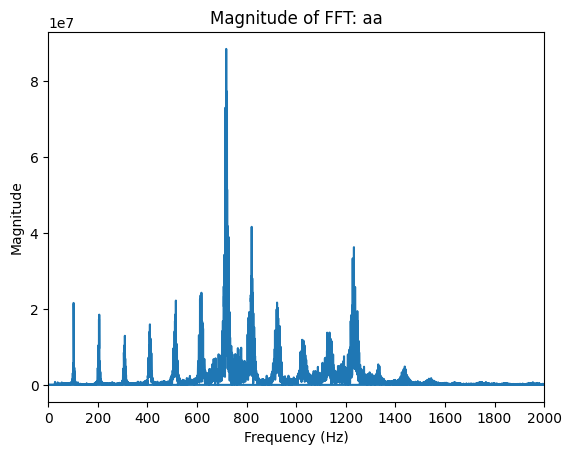

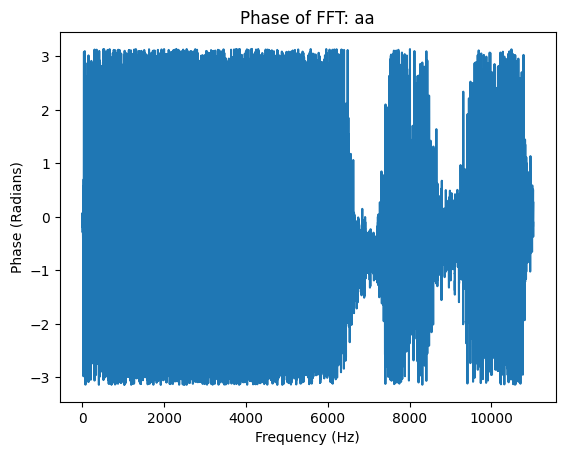

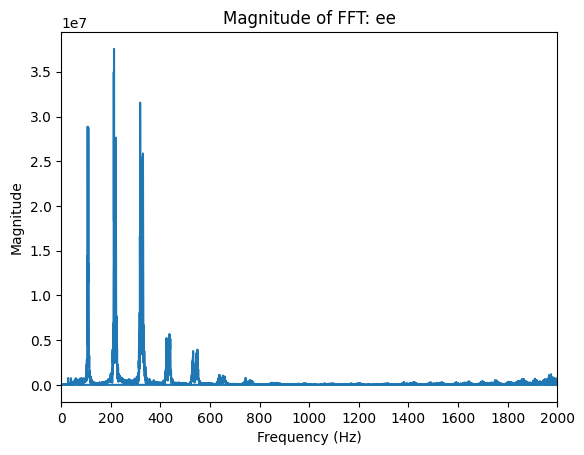

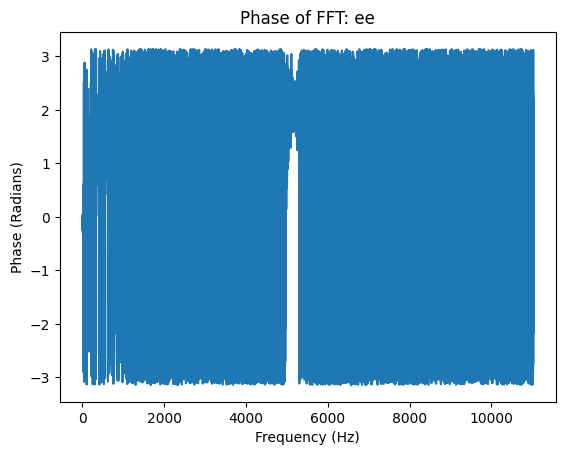

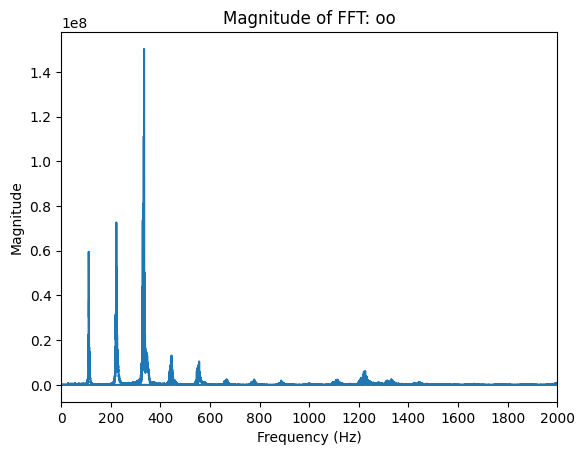

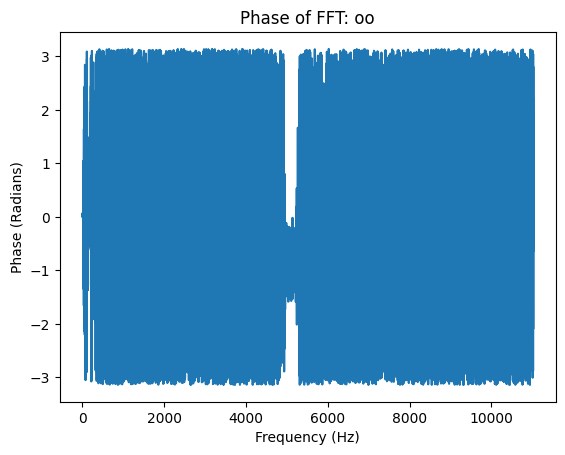

In [16]:
## Plot FFTs of extracted notes
for i, note in enumerate(notes):
    note_fft = np.fft.fft(note)
    N = len(note)
    xfreqs = np.fft.fftfreq(N, 1.0 / sr)
    notes_dict = {0: "aa", 1: "ee", 2: "oo"}
    plot_fft(xfreqs, note_fft, note=notes_dict[i])

#### Explanation

The "aa" sound appears to have more complex overtones. As the mouth closes, it concentrates the tone more and these overtones disappear considerably in the "ee" sound and a little bit more for the "oo" sound. Once again, the peaks are not necessarily the fundamental and might indicate something about the timbre of the voice.

The noisy phase diagram for the aa sound seems to have less noise for the higher frequencies. I wouldn't know what happened there, though since these are at very high frequencies, unrelated to where the voice sounds were made.


### Problem 4: STFT & Sound


In this section, you should do the following:

- Create an 22050 Hz audio signal containing a synthetic scale with eight notes: C4, D4, E4, F4, G4, A4, B4, C5. Each note should be a pure sinusoid and last exactly 1 second.
- Calculate the STFT. Make sure to adjust the parameters of the STFT for useful display, and include a magnitude plot of the interesting part of the matrix.
- For each of the three STFT parameters (window size, hop size, sampling rate), describe the pros & cons of increasing or decreasing the value. When would you want to increase or decrease the parameter value and why?
- Given a complete STFT (that includes the complex conjugate half) of the audio signal in (a), describe which coefficients in the matrix will have large magnitude. Your answer should contain algebraic expressions in terms in of $N$, $\Delta_{samples}$ , and $𝑓_s$.


Use as many code and Markdown cells as needed below to complete these tasks. Be sure to reuse your functions from before!


In [17]:
### INSERT CODE AND MARKDOWN CELLS BELOW ###
# Load and play audio
sr = 22050
x2 = load_audio("scale.wav", sr)
x2 = x2[: sr * 8]  # Cut off the signal at 8 seconds
ipd.Audio(x2, rate=sr)

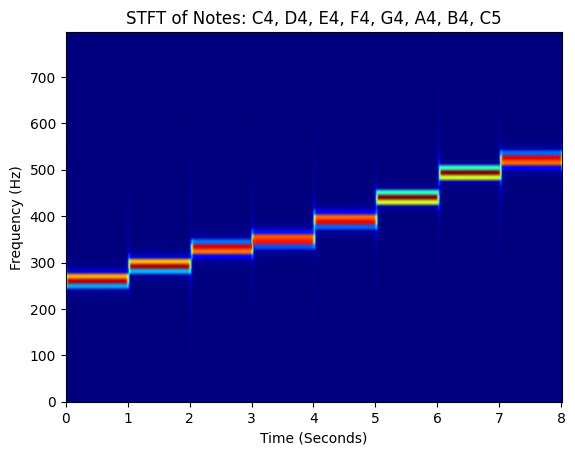

In [18]:
# STFT
winsize = 2048
hop = 128
f, t, S = stft(
    x2, fs=sr, window=hann(winsize, sym=False), nperseg=winsize, noverlap=winsize - hop
)

# limit freqs to go up to 800Hz
freq_indices = np.where((f <= 800))
f = f[freq_indices]
S = S[freq_indices, :][0]

plt.imshow(
    np.abs(S),
    origin="lower",
    cmap="jet",
    aspect="auto",
    extent=[t[0], t[-1], f[0], f[-1]],
)
plt.xlabel("Time (Seconds)")
plt.ylabel("Frequency (Hz)")
plt.ylim()
plt.title("STFT of Notes: C4, D4, E4, F4, G4, A4, B4, C5")
plt.show()

#### For each of the three STFT parameters (window size, hop size, sampling rate), describe the pros & cons of increasing or decreasing the value. When would you want to increase or decrease the parameter value and why?


**Window size**: By decreasing this value (in conjunction with hop size) you can save memory and time computing since you'll be computing the FFT less often and your STFT matrix will be smaller. A larger window size and hop leads to a higher resolution stft with less "noise" at frequencies near the actual frequency of the signal. The frequency bands are much more narrow.

**Hop size**: Again, in conjunction with decreasing window size, increasing the hop size can save memory and time computing. If it's too big, you won't be able to recover the input signal though. As the hop size gets smaller, the resolution increases and there is less overlap around the edges between different frequencies.

**Sampling rate**: You can compress your audio with a lower sampling rate. Since our signal is all Sine waves, lowering the sampling rate isn't going to change what we hear until we get around to the frequency of the sine wave itself. However, for more complex signals, increasing and decreasing sampling rate can also be a cool effect to speed up and slow down the audio and pitch it. When we plot these Sine signals as an STFT, decreasing the sampling rate makes the lines thinner since we are picking up less harmonics and artifacts (not perfect sine waves) until they almost vanish around 1kHz.


#### Given a complete STFT (that includes the complex conjugate half) of the audio signal in (a), describe which coefficients in the matrix will have large magnitude. Your answer should contain algebraic expressions in terms in of $N$, $\Delta_{samples}$ , and $𝑓_s$.


Since the signal was the frequencies

C4: 261.63 Hz
D4: 293.66 Hz
E4: 329.63 Hz
F4: 349.23 Hz
G4: 392.00 Hz
A4: 440.00 Hz
B4: 493.88 Hz
C5: 523.25 Hz

We should expect the STFT to have large magnitdues at indices $k$ that satisfy $f_s/N * k = \{261, 293, 329,...\}.$.


Solving for the $k$ values corresponding to those frequencies (below) will give the coefficients that will have large magnitudes.


In [19]:
np.array(
    [261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88, 523.25]
) * winsize // sr

array([24., 27., 30., 32., 36., 40., 45., 48.])

The corresponding frame indices will start at ($time * f_s)/\Delta_{samples}$ for times $\{0, 1, 2, ..., 7\}$ and extend for 172 frames. See below for the list of starting value:


In [20]:
np.array(range(8)) * sr // hop

array([   0,  172,  344,  516,  689,  861, 1033, 1205])

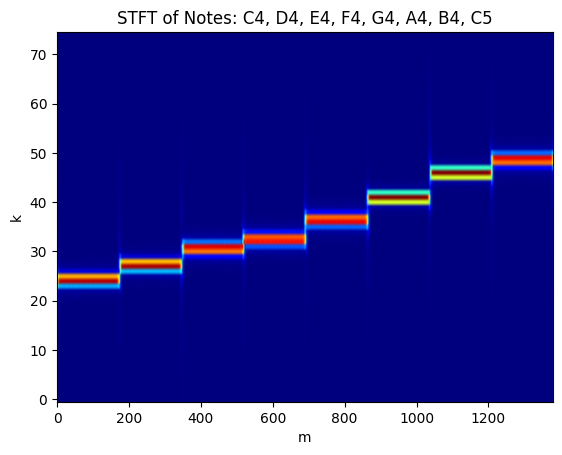

In [21]:
plt.imshow(
    np.abs(S),
    origin="lower",
    cmap="jet",
    aspect="auto",
)
plt.xlabel("m")
plt.ylabel("k")
plt.ylim()
plt.title("STFT of Notes: C4, D4, E4, F4, G4, A4, B4, C5")
plt.show()

### Problem 5: Exploring Sound


Similar to problems 2 and 3, pick one question of interest related to sound and conduct an investigation. Your exploration should contain three components:

- A clear question. Your investigation should have a clear question. For example, in problem 2, you investigated the question “How does the pitch of a note affect the spectra?”
- Data collection & analysis. You should record data and conduct data analysis using the DFT and STFT as tools.
- Observation & conclusion. Based on your data analysis, you should make a list of observations and come up with an answer to your question.


#### Research Question:

How do the edge artifacts inherent to an STFT (even with windowing) relate to the fundamental frequency? What artifacts are created? What other frequencies appear to be visible?

#### Method:

- Record a scale of pure sine waves. Each note should be one second long.
- Plot the STFT such that the harmonics are visible. Needs to be high resolution.
- Plot the highest magnitude value in each frame (max harmonic) and lowest significant value in each frame (fundamental frequency) against each other. A perfect sine wave with no artifacts would have a one-to-one relationship with no points above or below the line of best fit.


In [22]:
### INSERT CODE AND MARKDOWN CELLS BELOW ###

# Load and play audio
sr = 22050
sweep = load_audio("scale.wav", sr)
sweep = sweep[: sr * 8]  # Cut off the signal at 8 seconds
ipd.Audio(sweep, rate=sr)

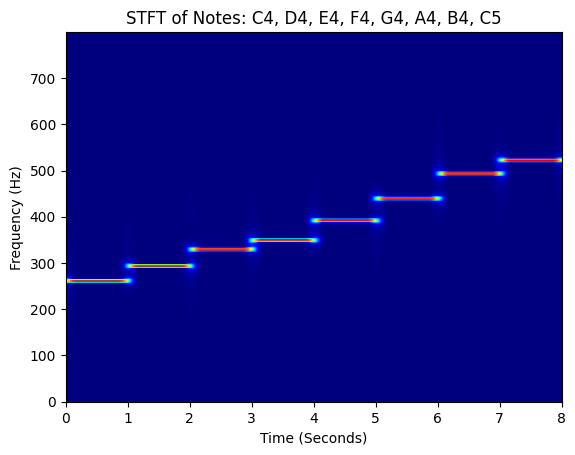

In [23]:
# STFT
winsize = 8192
hop = 64
f, t, S = stft(
    sweep,
    fs=sr,
    window=hann(winsize, sym=False),
    nperseg=winsize,
    noverlap=winsize - hop,
)

# limit freqs to go up to 800 Hz
freq_indices = np.where((f <= 800))
f = f[freq_indices]
S = S[freq_indices, :][0]

plt.imshow(
    np.abs(S),
    origin="lower",
    cmap="jet",
    aspect="auto",
    extent=[t[0], t[-1], f[0], f[-1]],  # type: ignore
)
plt.xlabel("Time (Seconds)")
plt.ylabel("Frequency (Hz)")
plt.ylim()
plt.title("STFT of Notes: C4, D4, E4, F4, G4, A4, B4, C5")
plt.show()

In [24]:
def find_fundamental(a: np.ndarray, sr, N, threshold=0.3):
    # sweep from lowest freq to find the first one past the threshold
    limit = np.max(np.abs(a)) * threshold
    for i, k in enumerate(a):
        if np.abs(k) > limit:
            return i * sr // N
    return np.nan

In [25]:
def find_max_index(a: np.ndarray, sr, N):
    # sweep the whole range, get max.
    return np.argmax(np.abs(a)) * sr // N

In [26]:
# loop through the stft frames, pull out the fundamental and the max index
fundamentals = []
maxes = []

print(S.shape)

for m in range(S.shape[1]):
    m_slice = S[:, m]
    # plt.show()
    # plt.plot(np.abs(m_slice))
    # print(find_fundamental(m_slice, sr, N))
    fundamentals.append(find_fundamental(m_slice, sr, winsize))
    maxes.append(find_max_index(m_slice, sr, winsize))

(298, 2758)


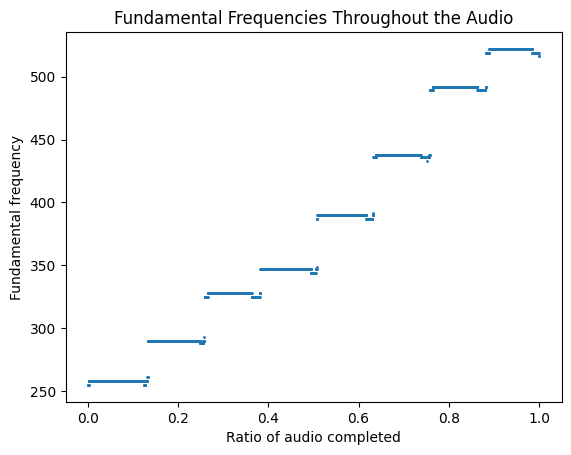

In [27]:
x = np.linspace(0, 1, len(fundamentals))
plt.scatter(x, fundamentals, s=1)
plt.xlabel("Ratio of audio completed")
plt.ylabel("Fundamental frequency")
plt.title("Fundamental Frequencies Throughout the Audio")
plt.show()

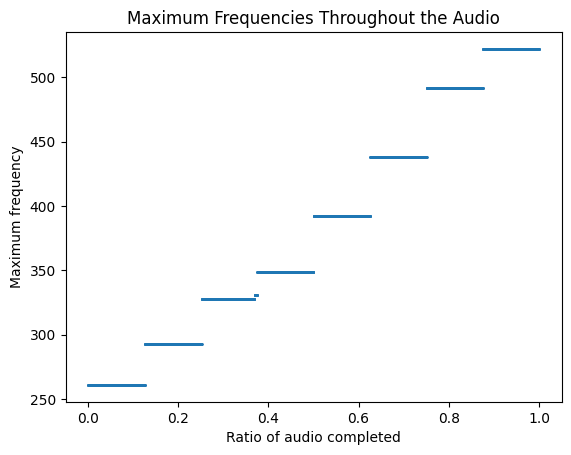

In [28]:
x = np.linspace(0, 1, len(maxes))
plt.scatter(x, maxes, s=1)
plt.xlabel("Ratio of audio completed")
plt.ylabel("Maximum frequency")
plt.title("Maximum Frequencies Throughout the Audio")
plt.show()

Slope of line of best fit: 0.9876883707053963


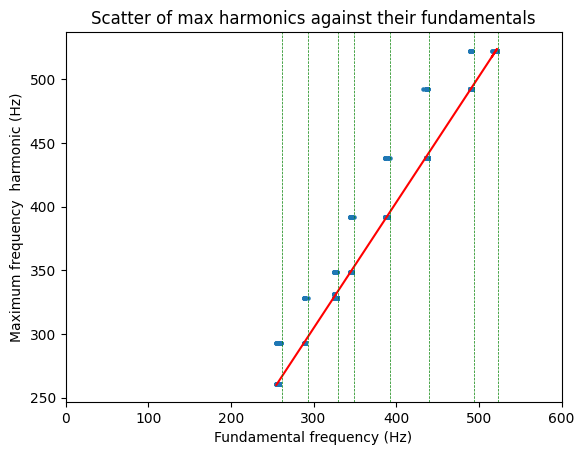

In [29]:
N = len(fundamentals)
fundamentals = np.abs(fundamentals)
maxes = np.abs(maxes)
m, b = np.polyfit(fundamentals, maxes, deg=1)
plt.plot(fundamentals, m * fundamentals + b, c="red")
notes = [
    261.63,
    293.66,
    329.63,
    349.23,
    392.00,
    440.00,
    493.88,
    523.25,
]
for note in notes:
    plt.axvline(note, linestyle="--", c="green", linewidth=0.5)
plt.scatter(fundamentals, maxes, s=5)
print(f"Slope of line of best fit: {m}")
# plt.plot(fundamentals, fundamentals)
plt.xlabel("Fundamental frequency (Hz)")
plt.ylabel("Maximum frequency  harmonic (Hz)")
plt.xlim(0, 600)
plt.title("Scatter of max harmonics against their fundamentals")
plt.show()

As seen in the plot above, the line of best fit have a slope of 0.987, which is nearly the expected value of 1 but is indicative of some noise/artifacting. The notes on the red line (line of best fit) directly intersect with the vertical lines that correspond to the frequencies of each note on the scale. The higher harmonics seem to have another linear relationship, but they do not line up exactly with the expected frequencies. They are essentially an upward and slightly left shift. This all seems to indicate that the STFT does a good job of pulling pure frequencies out of an audio sample, but it does introduce artifacts that may need to be tuned with hyperparamters or otherwise compensated for.
